In [1]:
import torch
from torch import nn
from PIL import Image
import numpy as np

<class 'PIL.Image.Image'>


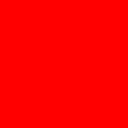

In [2]:
img = Image.new('RGB', (128, 128), color = 'red')
print(type(img))
img.show()

In [57]:
img_array = np.array(img)
img_array = img_array/255
img_array = img_array.transpose(2, 0, 1).astype(np.float32)

In [5]:
img_tensor = torch.from_numpy(img_array)
img_tensor = img_tensor.unsqueeze(0)
print(img_tensor.shape)

torch.Size([1, 3, 128, 128])


In [2]:
def image_to_tensor(image: Image) -> torch.Tensor:
    img_array = np.array(image)
    img_array = img_array/255
    img_array = img_array.transpose(2, 0, 1).astype(np.float32)
    img_tensor = torch.from_numpy(img_array)
    img_tensor = img_tensor.unsqueeze(0)
    return img_tensor

def tensor_to_image(tensor: torch.Tensor) -> Image:
    img_array = tensor.squeeze(0).numpy()
    img_array = img_array.transpose(1, 2, 0)
    img_array = img_array*255
    img_array = img_array.astype(np.uint8)
    image = Image.fromarray(img_array)
    return image

In [3]:
color = tuple[int, int, int]
def create_empty_image(resolution: int, color: color=(0,0,0)) -> Image:
    return Image.new('RGB', (resolution, resolution), color = color)

In [8]:
init_tensor = image_to_tensor(create_empty_image(128, color=(255, 0, 0)))
target_tensor = image_to_tensor(create_empty_image(128, color=(0, 255, 0)))

step : 0, loss :  197.142807)
step : 1, loss :  195.537323)
step : 2, loss :  192.305786)
step : 3, loss :  187.487595)
step : 4, loss :  181.057846)
step : 5, loss :  173.021378)
step : 6, loss :  163.378113)
step : 7, loss :  152.129456)
step : 8, loss :  139.289001)
step : 9, loss :  124.844475)
step : 10, loss :  108.810753)
step : 11, loss :  91.206413)
step : 12, loss :  72.061035)
step : 13, loss :  51.459583)
step : 14, loss :  29.770758)
step : 15, loss :  10.977227)
step : 16, loss :  23.008425)
step : 17, loss :  44.916439)
step : 18, loss :  66.090446)
step : 19, loss :  85.873528)
step : 20, loss :  104.130600)
step : 21, loss :  120.815468)
step : 22, loss :  135.920227)
step : 23, loss :  149.437439)
step : 24, loss :  161.338669)
step : 25, loss :  171.651688)
step : 26, loss :  180.352875)
step : 27, loss :  187.449570)
step : 28, loss :  192.937790)
step : 29, loss :  196.819717)
step : 30, loss :  199.093430)
step : 31, loss :  199.759125)
step : 32, loss :  198.8243

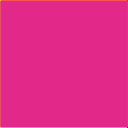

In [9]:
# init_tensor.grad  
conv = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, padding=1)
lr = 1e-5
num_step = 100

for step in range(num_step):
    y = conv(init_tensor)
    loss = (y - target_tensor).norm()
    loss.backward()

    with torch.no_grad():
        print(f'step : {step}, loss : {loss.item(): 3f})')
        for param in conv.parameters():
            assert param.grad is not None
            param -= lr * param.grad
    # conv.zero_grad()

result = conv(init_tensor)
tensor_to_image(result.data)



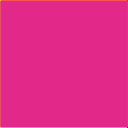

In [10]:
tensor_to_image(conv(init_tensor).detach())

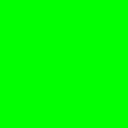

In [11]:
tensor_to_image(target_tensor)

In [4]:
class Linear(nn.Module):
    def __init__(self, in_features: int=1, out_features: int=1) -> None:
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = nn.Parameter(torch.randn(out_features, in_features))
        self.bias = nn.Parameter(torch.randn(out_features))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return x @ self.weight.t() + self.bias

linear = Linear(in_features=3, out_features=3)
x = torch.randn(1, 3)
target_tensor = torch.randn(1, 3)
y = linear(x)
loss = ((y - target_tensor)**2).mean()
loss.backward()

In [13]:
linear.weight.grad

tensor([[-0.2100,  0.0452, -0.6306],
        [ 0.2792, -0.0601,  0.8381],
        [-0.2378,  0.0512, -0.7139]])

In [5]:
class Resblock(nn.Module):
    def __init__(self, in_channels : int = 1, out_channels : int = 1) -> None:
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, padding=1)
        self.activation = nn.SiLU()
        self.conv2 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, padding=1)
    def forward(self, x : torch.Tensor) -> torch.Tensor:
        y = self.conv1(x)
        y = self.activation(y)
        y = self.conv2(y)
        # y = self.activation(y)
        return y + x


In [15]:
block = Resblock(in_channels = 3, out_channels =3)

lr = 1e-5
num_step = 10000
for step in range(num_step):
    y = block(init_tensor)
    loss = (y - target_tensor).norm()
    loss.backward()

    with torch.no_grad():
        print(f'step : {step}, loss : {loss.item(): 3f})')
        for param in block.parameters():
            assert param.grad is not None
            param -= lr * param.grad
    # conv.zero_grad()
            
result = conv(init_tensor)
tensor_to_image(result.data)


RuntimeError: The size of tensor a (128) must match the size of tensor b (3) at non-singleton dimension 3

In [49]:
class Encoder(nn.Module):
    def __init__(self, input_channels: int = 3):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1)
        self.conv5 = nn.Conv2d(256, 4, 1, padding=0)
        self.silu = nn.SiLU()
        self.maxpool = nn.MaxPool2d(2)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        y = self.conv1(x)
        y = self.silu(y)
        y = self.maxpool(y)
        y = self.conv2(y)
        y = self.silu(y)
        y = self.maxpool(y)
        y = self.conv3(y)
        y = self.silu(y)
        y = self.maxpool(y)
        y = self.conv4(y)
        y = self.silu(y)
        y = self.maxpool(y)
        y = self.conv5(y)
        return y

class Decoder(nn.Module):
    def __init__(self, output_channels: int = 3):
        super().__init__()
        self.conv0 = nn.Conv2d(4, 256, 1, padding=0)
        self.conv1 = nn.Conv2d(256, 128, 3, padding=1)
        self.conv2 = nn.Conv2d(128, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 32, 3, padding=1)
        self.conv4 = nn.Conv2d(32, output_channels, 3, padding=1)
        self.silu = nn.SiLU()
        self.upsample = nn.Upsample(scale_factor=2)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        y = self.conv0(x)
        y = self.conv1(y)
        y = self.silu(y)
        y = self.upsample(y)
        # print("decoder, conv1_1 et conv 1" ,y.shape)
        y = self.conv2(y)
        y = self.silu(y)
        y = self.upsample(y)
        # print("decoder, conv2" ,y.shape)
        y = self.conv3(y)
        y = self.silu(y)
        y = self.upsample(y)
        # print("decoder, conv3" ,y.shape)
        y = self.conv4(y)
        y = self.silu(y)
        y = self.upsample(y)
        # print("decoder, conv4" ,y.shape)
        return y

In [34]:
class Autoencoder(nn.Module):
    def __init__(self) -> None:
        super().__init__() # type: ignore
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.decoder(self.encoder(x))


In [35]:
class Dataset:
    def __init__(self) -> None:
        self.data = list(range(100))

    def __len__(self) -> int:
        return len(self.data)

    def __str__(self) -> str:
        return f'Dataset(len={len(self)})'

    def __repr__(self) -> str:
        return str(self)
    
    def __getitem__(self, key : str|int) -> int:
        match key:
            case key if isinstance(key, str):
                raise ValueError('Dataset does not take string as index.')
            case _:
                return self.data[key]


In [19]:
dataset = Dataset()
dataset[2]
# print(dataset)

2

In [36]:
device = torch.device('cuda')

step 0 : loss 124.7420883178711
step 1 : loss 124.46776580810547
step 2 : loss 124.17717742919922
step 3 : loss 123.85760498046875
step 4 : loss 123.49578094482422
step 5 : loss 123.06446838378906
step 6 : loss 122.53224182128906
step 7 : loss 121.86459350585938
step 8 : loss 121.01408386230469
step 9 : loss 119.90970611572266
step 10 : loss 118.47626495361328
step 11 : loss 116.60877990722656
step 12 : loss 114.1825942993164
step 13 : loss 111.03224182128906
step 14 : loss 106.95996856689453
step 15 : loss 101.7313461303711
step 16 : loss 95.07386016845703
step 17 : loss 86.69741821289062
step 18 : loss 76.39803314208984
step 19 : loss 64.34163665771484
step 20 : loss 52.09644317626953
step 21 : loss 45.83066177368164
step 22 : loss 52.42335891723633
step 23 : loss 57.16010284423828
step 24 : loss 54.325843811035156
step 25 : loss 47.93583679199219
step 26 : loss 42.39128494262695
step 27 : loss 40.17490005493164
step 28 : loss 40.76582336425781
step 29 : loss 42.22091293334961
step 3

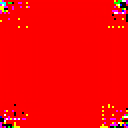

In [25]:
autoencoder = Autoencoder()
lr = 1e-4
num_steps = 1000
optimizer = torch.optim.Adam(autoencoder.parameters() , lr=lr)
for step in range(num_steps):
    y = autoencoder(init_tensor)
    loss = (y-init_tensor).norm()
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    print(f"step {step} : loss {loss.item()}")

result = autoencoder(init_tensor)
tensor_to_image(result.data)


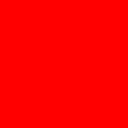

In [26]:
tensor_to_image(init_tensor)

In [37]:
from PIL import Image, ImageDraw
import random

def generate_image(size): # , num_images):
    # for i in range(num_images):
    # Create a new image with a random background color
    img = Image.new("RGB", size, color=(random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)))

    # Get a drawing context
    draw = ImageDraw.Draw(img)

    # Choose a random shape (circle, square, or triangle)
    # shape = random.choice(["circle", "square", "triangle"])
    shape = "circle"

    # Choose a random position
    position = (random.randint(20, size[0]-20), random.randint(20, size[1]-20))

    # Choose a random color for the shape
    shape_color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))

    # Draw the shape on the image
    if shape == "circle":
        draw.ellipse([position[0]-20, position[1]-20, position[0]+20, position[1]+20], fill=shape_color)
    elif shape == "square":
        draw.rectangle([position[0]-20, position[1]-20, position[0]+20, position[1]+20], fill=shape_color)
    elif shape == "triangle":
        draw.polygon([(position[0], position[1]-20), (position[0]-20, position[1]+20), (position[0]+20, position[1]+20)], fill=shape_color)

    # Show the image
    # img.show()
    # print(type(img))
    return img

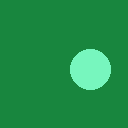

In [38]:
image_size = (128, 128)
num_images = 5  # Change this to the number of images you want to generate

new_image = generate_image(image_size)
new_image.show()

step 0 : loss 83.34357452392578
step 1 : loss 82.53295135498047
step 2 : loss 81.6451187133789
step 3 : loss 80.62083435058594
step 4 : loss 79.39480590820312
step 5 : loss 77.8953628540039
step 6 : loss 76.04495239257812
step 7 : loss 73.77063751220703
step 8 : loss 71.00028991699219
step 9 : loss 67.67150115966797
step 10 : loss 63.763824462890625
step 11 : loss 59.359371185302734
step 12 : loss 54.781227111816406
step 13 : loss 50.88703536987305
step 14 : loss 49.23735809326172
step 15 : loss 50.02930450439453
step 16 : loss 50.100303649902344
step 17 : loss 48.01298904418945
step 18 : loss 44.690284729003906
step 19 : loss 41.461368560791016
step 20 : loss 39.198734283447266
step 21 : loss 38.00797653198242
step 22 : loss 37.43558120727539
step 23 : loss 36.97111511230469
step 24 : loss 36.3299560546875
step 25 : loss 35.461849212646484
step 26 : loss 34.484989166259766
step 27 : loss 33.62495422363281
step 28 : loss 33.12342834472656
step 29 : loss 33.0842399597168
step 30 : loss 

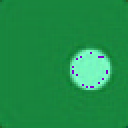

In [50]:
new_init_tensor = image_to_tensor(new_image)
# print(new_init_tensor.shape)

autoencoder = Autoencoder()
lr = 1e-4
num_steps = 1000
optimizer = torch.optim.Adam(autoencoder.parameters() , lr=lr)
for step in range(num_steps):
    y = autoencoder(new_init_tensor)
    # print(y.shape)
    loss = (y-new_init_tensor).norm()
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    print(f"step {step} : loss {loss.item()}")

result = autoencoder(new_init_tensor)
tensor_to_image(result.data)

In [51]:
num_images_train = 20
num_images_test = 5
dataset_train = [None] * num_images_train
dataset_test = [None] * num_images_test

for i in range(num_images_train):
    dataset_train[i] = image_to_tensor(generate_image(image_size))

for i in range(num_images_test):
    dataset_test[i] = image_to_tensor(generate_image(image_size))

# dataset

In [52]:
autoencoder = Autoencoder()
autoencoder.train()
lr = 1e-4
num_steps = 1000

optimizer = torch.optim.Adam(autoencoder.parameters() , lr=lr)
for step in range(num_steps):
    loss_iter = 0
    for image in dataset_train:
        y = autoencoder(image)
        loss = (y-image).norm()
        loss_iter += loss
    loss = loss_iter/num_images_train
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    print(f"step {step} : loss {loss.item()}")

# result = autoencoder(new_init_tensor)
# tensor_to_image(result.data)

step 0 : loss 132.61376953125
step 1 : loss 131.64112854003906
step 2 : loss 130.5806121826172
step 3 : loss 129.34437561035156
step 4 : loss 127.84871673583984
step 5 : loss 126.00630950927734
step 6 : loss 123.7280502319336
step 7 : loss 120.91514587402344
step 8 : loss 117.4564437866211
step 9 : loss 113.2298355102539
step 10 : loss 108.11158752441406
step 11 : loss 102.01224517822266
step 12 : loss 94.96006774902344
step 13 : loss 87.30363464355469
step 14 : loss 80.12794494628906
step 15 : loss 75.85962677001953
step 16 : loss 77.81075286865234
step 17 : loss 83.12570190429688
step 18 : loss 84.24937438964844
step 19 : loss 81.36972045898438
step 20 : loss 77.34535217285156
step 21 : loss 74.3086929321289
step 22 : loss 73.00001525878906
step 23 : loss 73.07252502441406
step 24 : loss 73.79420471191406
step 25 : loss 74.55781555175781
step 26 : loss 75.02159118652344
step 27 : loss 75.05724334716797
step 28 : loss 74.6686019897461
step 29 : loss 73.93714904785156
step 30 : loss 72

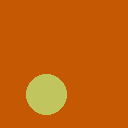

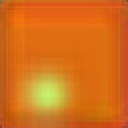

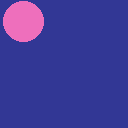

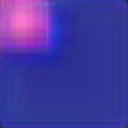

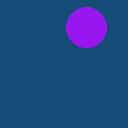

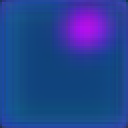

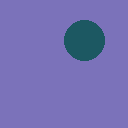

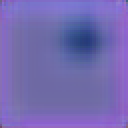

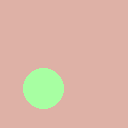

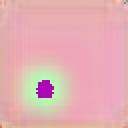

In [53]:
autoencoder.eval()
for image in dataset_test:
    result = autoencoder(image)
    tensor_to_image(image.data).show()
    tensor_to_image(result.data).show()
